In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys

path0 = 'D:/SAWS_code'
path = path0 + '/real_electricity_prediction'
sys.path.append(path0)

from read_data import read_electricity
from environments import real_linear_reg_env
from algorithms import SAWS_online, MA

In [2]:
# read data
year_start = 2016
year_end = 2020
data = read_electricity(year_start, year_end)

# response and features
demand = np.array(data['demand'])
min_temp = np.array(data['min_temperature'])
max_temp = np.array(data['max_temperature'])
solar = np.array(data['solar_exposure'])
rain = np.array(data['rainfall'])

scale = 5e-4
batches = [[[np.array([min_temp[k], max_temp[k], solar[k], rain[k], 1]), demand[k+1] * scale]] for k in range(len(demand)-1)]

data

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,year
365,2016-01-01,116040.925,32.527673,116040.925,32.527673,0.000,0.000000,0.000000,19.8,24.2,22.0,0.0,N,Y,2016
366,2016-01-02,99622.640,21.894561,99622.640,21.894561,0.000,0.000000,0.000000,17.1,27.6,25.1,0.0,N,N,2016
367,2016-01-03,97656.445,19.895385,97656.445,19.895385,0.000,0.000000,0.000000,17.5,27.1,25.7,0.0,N,N,2016
368,2016-01-04,110932.505,25.443479,110932.505,25.443479,0.000,0.000000,0.000000,16.3,26.0,15.3,0.0,N,N,2016
369,2016-01-05,117873.580,29.917187,117873.580,29.917187,0.000,0.000000,0.000000,17.1,25.7,25.8,0.0,N,N,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,N,N,2020
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N,2020
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,N,N,2020
2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,N,N,2020


In [3]:
# problem parameters
d = len(batches[0][0][0])
N = len(batches)
M = np.inf

# compute per-period loss
def lin_reg_loss(forecast, actual, features):
    return np.mean([(actual[t]-np.dot(forecast[t],features[t]))**2 for t in range(len(actual))])

In [4]:
##### SAWS #####

# initialize environment
env = real_linear_reg_env(d, N, batches, M)
loss = env.get_loss()
solver = env.get_solver()

# run SAWS
param = {'B':1, 'tau':10, 'alpha':0.1, 'geo_wind':True, 'reuse':False, 'compute_reg':False}
dcsn_list_SAWS, wind_list, _ = SAWS_online(env, loss, param, np.zeros(d), solver)

# record decisions
forecast_SAWS = dcsn_list_SAWS[:-1]

# compute per-period loss
actual = [batches[t+1][0][1] for t in range(len(batches)-1)]
features = [batches[t+1][0][0] for t in range(len(batches)-1)]
SAWS_avgreg = lin_reg_loss(forecast_SAWS, actual, features)

# record window sizes
wind = np.array(wind_list)
right = np.array([i + 1 for i in range(N)])
left = right - wind
SAWS_windows = (left, right)

In [5]:
##### MA #####

MA_avgreg = dict()   # stores per-period losses of different fixed-window benchmarks
MA_dcsns = dict()      # stores decisions of different fixed-window benchmarks
wind_cand = [1, 7, 14, 30, 180, 365, 1826]      # fixed window sizes

for wind in wind_cand:

    # initialize environment
    env = real_linear_reg_env(d, N, batches, M)
    loss = env.get_loss()
    solver = env.get_solver()

    # run Moving Average
    param = {'B':1, 'wind':wind, 'compute_reg':False}
    dcsn_list_MA, _ = MA(env, param, np.zeros(d), solver)

    # record decisions
    forecast_MA = dcsn_list_MA[:-1]
    MA_dcsns[wind] = forecast_MA

    # compute per-period loss
    actual = [batches[t+1][0][1] for t in range(len(batches)-1)]
    features = [batches[t+1][0][0] for t in range(len(batches)-1)]
    MA_avgreg[wind] = lin_reg_loss(forecast_MA, actual, features)

In [6]:
print('Per-period loss of SAWS = {}\n'.format(SAWS_avgreg))
print('Per-period loss of MA(k) =')
MA_avgreg

Per-period loss of SAWS = 46.24274809464158

Per-period loss of MA(k) =


{1: 201.83409367888257,
 7: 611.1450610149371,
 14: 95.70824695402823,
 30: 45.77885272522814,
 180: 55.55080631464842,
 365: 51.67155158078627,
 1826: 52.1490361897247}

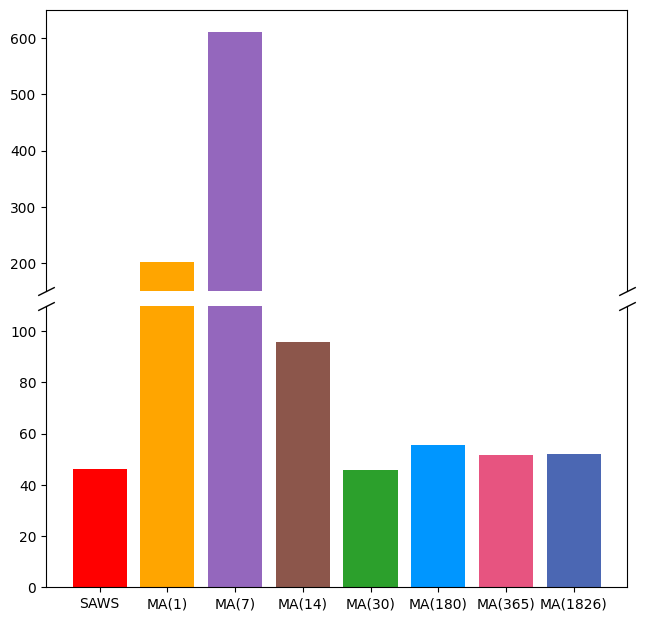

In [7]:
# plot per-period loss
methods = ['SAWS'] + ['MA(' + str(wind) + ')' for wind in wind_cand]
colors = ['red', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF', '#E75480', '#4B67B3', '#50BA90', '#E8895D']

# break y axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (7.5, 7.5))
fig.subplots_adjust(hspace=0.05)
ax1.bar(range(len(methods)), [SAWS_avgreg] + [MA_avgreg[k] for k in wind_cand], color=colors, width = 0.8)
ax2.bar(range(len(methods)), [SAWS_avgreg] + [MA_avgreg[k] for k in wind_cand], color=colors, width = 0.8)
ax1.set_ylim(150, 650)
ax2.set_ylim(0, 110)
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.set_ticks_position('none')
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

kwargs = dict(marker=[(-1, -0.5), (1, 0.5)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods)

plt.savefig('figures/bar_electricity.pdf')

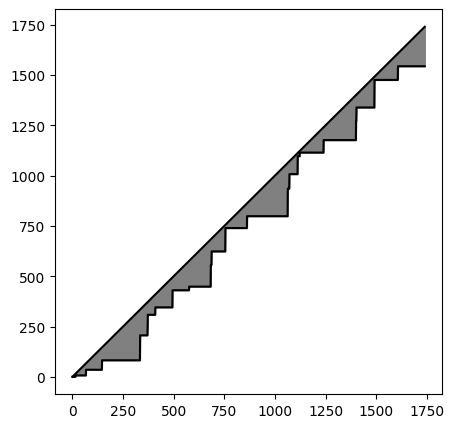

In [8]:
# plot selected windows of SAWS
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
plt.plot(range(N), SAWS_windows[0], color='black')
plt.plot(range(N), SAWS_windows[1], color='black')
plt.fill_between(range(N), SAWS_windows[0], SAWS_windows[1], color='grey')

plt.savefig('figures/windows_electricity.pdf')

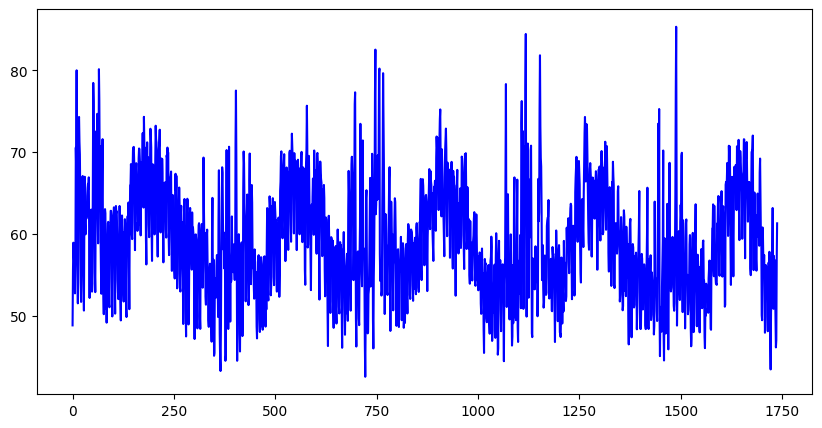

In [9]:
# plot non-stationarity pattern
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
plt.plot(range(len(actual)), actual, color='blue',label='True')
plt.savefig('figures/pattern_electricity.pdf')